In [5]:
import pandas as pd
import numpy as np
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import train_test_split

In [6]:
import gdown
output = "df_inegi_coneval_limpio.csv"
df = pd.read_csv('df_inegi_coneval_limpio.csv')

In [7]:
df.head()

,clave_entidad,NOM_ENT,MUN,municipio,POBTOT,POBFEM,POBMAS,P_0A2,P_0A2_F,P_0A2_M,...,VPH_INTER,VPH_STVP,VPH_SPMVPI,VPH_CVJ,VPH_SINRTV,VPH_SINLTC,VPH_SINCINT,VPH_SINTIC,pobreza_pob,ic_sbv_pob
0,1,Aguascalientes,1,Aguascalientes,948990,486917,462073,44372,21893,22479,...,178619,130290,80951,56131,3299,7293,74227,731,218414,10473
1,1,Aguascalientes,2,Asientos,51536,26275,25261,3170,1639,1531,...,4526,3882,596,556,377,1447,7206,177,19518,3604
2,1,Aguascalientes,3,Calvillo,58250,29687,28563,3159,1581,1578,...,6553,4749,1382,1352,443,904,8061,138,23966,1612
3,1,Aguascalientes,4,Cosío,17000,8708,8292,1032,539,493,...,1741,1664,223,191,139,414,1912,50,5905,701
4,1,Aguascalientes,5,Jesús María,129929,65710,64219,6945,3380,3565,...,19920,13483,9296,6582,480,1150,11447,148,33708,2952


In [8]:
df_final = df.select_dtypes(include=[np.number])

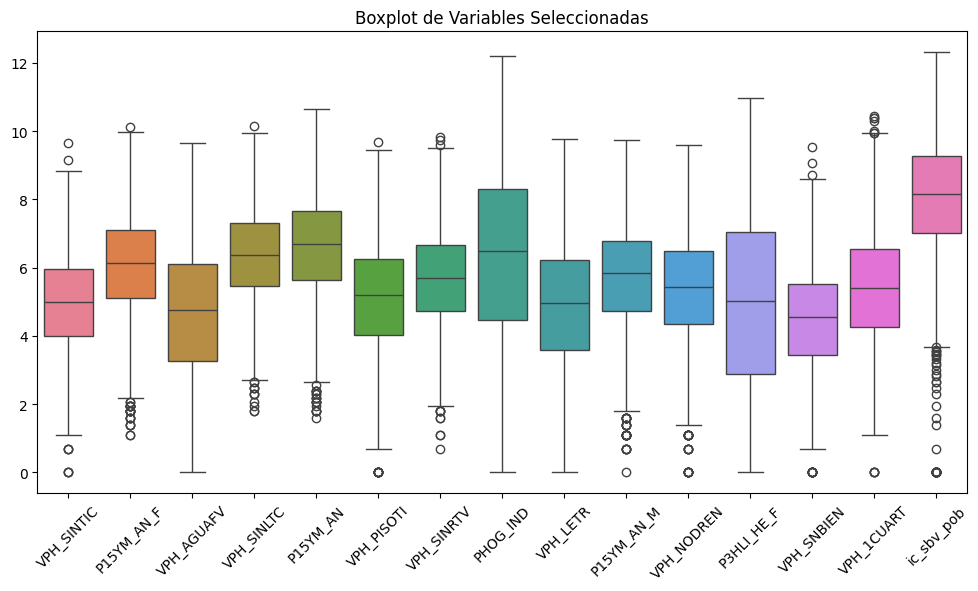

In [11]:
df_log = df_final.copy()
for col in df_log.columns:
    df_log[col] = np.log1p(df_log[col])

plt.figure(figsize=(12, 6))

sns.boxplot(data=df_log[selected_features])

plt.xticks(rotation=45)

plt.title("Boxplot de Variables Seleccionadas")
plt.show()

In [13]:
from sklearn.preprocessing import MinMaxScaler
scaler = MinMaxScaler(feature_range=(0, 1))
df_normalizado = pd.DataFrame(scaler.fit_transform(df_log), columns=df_log.columns)

In [15]:
df_normalizado = df_normalizado.drop(columns=['clave_entidad', 'MUN'])

# Neural Networks & XG Boost ambos indicadores

## Pobreza Pob

In [40]:
features_pob = [
    "PSINDER",
    "VPH_SINCINT",
    "VPH_NDACMM",
    "VPH_2CUART",
    "P15PRI_INF",
    "VPH_SINLTC",
    "PDESOCUP_M",
    "PDESOCUP",
    "P15YM_SE_F",
    "P_8A14_F"
]

target_pob = "pobreza_pob"

X = df_normalizado[features_pob]
y = df_normalizado[target_pob]

X_train_p, X_test, y_train_p, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

X_train_p, X_valid_p, y_train_p, y_valid_p = train_test_split(
    X_train_p, y_train_p, test_size=0.2, random_state=42
)

# XGBoost Pobreza Pob

In [43]:
from sklearn.model_selection import RandomizedSearchCV, GridSearchCV, cross_validate
from xgboost import XGBRegressor
from sklearn.metrics import r2_score, mean_squared_error
import numpy as np
import pandas as pd

param_dist_xgb = {
    'n_estimators': [50, 100, 200],
    'learning_rate': np.linspace(0.01, 0.2, 4),
    'max_depth': [2, 3, 4, 5],
    'subsample': np.linspace(0.5, 0.9, 3),
    'colsample_bytree': np.linspace(0.5, 0.9, 3),
    'gamma': np.linspace(0, 0.3, 3),
    'reg_alpha': np.linspace(0, 0.5, 3),
    'reg_lambda': np.linspace(0.5, 2, 3),
    'min_child_weight': [1, 3, 5]
}

xgb_model = XGBRegressor(
    objective="reg:squarederror",
    random_state=42,
    eval_metric="rmse"
)

# -------------------------------
# Fase 1: RandomizedSearchCV (Búsqueda rápida en espacio amplio)
# -------------------------------
random_search_xgb = RandomizedSearchCV(
    estimator=xgb_model,
    param_distributions=param_dist_xgb,
    n_iter=10,
    scoring="r2",
    cv=3,
    verbose=1,
    n_jobs=4,
    random_state=42
)

random_search_xgb.fit(X_train_p, y_train_p, eval_set=[(X_valid_p, y_valid_p)], verbose=False)
best_params_random = random_search_xgb.best_params_
print(f"Mejores parámetros después de RandomSearch: {best_params_random}\n")

# -------------------------------
# Fase 2: GridSearchCV (Refinamiento en espacio reducido)
# -------------------------------
param_grid_xgb = {
    'n_estimators': list(set([max(50, best_params_random['n_estimators'] - 50), best_params_random['n_estimators'], best_params_random['n_estimators'] + 50])),
    'learning_rate': list(set([best_params_random['learning_rate'] * 0.8, best_params_random['learning_rate'], best_params_random['learning_rate'] * 1.2])),
    'max_depth': list(set([max(2, best_params_random['max_depth'] - 1), best_params_random['max_depth'], min(6, best_params_random['max_depth'] + 1)])),
    'subsample': list(set([max(0.5, best_params_random['subsample'] - 0.1), best_params_random['subsample'], min(0.9, best_params_random['subsample'] + 0.1)])),
    'colsample_bytree': list(set([max(0.5, best_params_random['colsample_bytree'] - 0.1), best_params_random['colsample_bytree'], min(0.9, best_params_random['colsample_bytree'] + 0.1)])),
    'gamma': list(set([max(0, best_params_random['gamma'] - 0.05), best_params_random['gamma'], min(0.3, best_params_random['gamma'] + 0.05)])),
    'reg_alpha': list(set([max(0, best_params_random['reg_alpha'] - 0.05), best_params_random['reg_alpha'], min(0.5, best_params_random['reg_alpha'] + 0.05)])),
    'reg_lambda': list(set([max(0.5, best_params_random['reg_lambda'] - 0.2), best_params_random['reg_lambda'], min(2, best_params_random['reg_lambda'] + 0.2)])),
    'min_child_weight': list(set([max(1, best_params_random['min_child_weight'] - 1), best_params_random['min_child_weight'], min(7, best_params_random['min_child_weight'] + 1)]))
}

grid_search_xgb = GridSearchCV(
    estimator=xgb_model,
    param_grid=param_grid_xgb,
    scoring="r2",
    cv=3,
    verbose=1,
    n_jobs=4
)

grid_search_xgb.fit(X_train_p, y_train_p, eval_set=[(X_valid_p, y_valid_p)], verbose=False)
best_xgb = grid_search_xgb.best_estimator_
print(f"Mejores parámetros después de GridSearch: {grid_search_xgb.best_params_}\n")

y_train_pred = best_xgb.predict(X_train_p)
y_test_pred = best_xgb.predict(X_test)

r2_train = r2_score(y_train_p, y_train_pred)
mse_train = mean_squared_error(y_train_p, y_train_pred)
r2_test = r2_score(y_test, y_test_pred)
mse_test = mean_squared_error(y_test, y_test_pred)

results_xgb = {
    "Model": "MLP Regressor (Optimizado)",
    "R² Train": r2_train,
    "MSE Train": mse_train,
    "R² Test": r2_test,
    "MSE Test": mse_test
}

df_results_xgb = pd.DataFrame([results_xgb])
df_results_xgb


Fitting 3 folds for each of 10 candidates, totalling 30 fits
Mejores parámetros después de RandomSearch: {'subsample': 0.7, 'reg_lambda': 0.5, 'reg_alpha': 0.0, 'n_estimators': 100, 'min_child_weight': 5, 'max_depth': 3, 'learning_rate': 0.1366666666666667, 'gamma': 0.15, 'colsample_bytree': 0.5}

Fitting 3 folds for each of 5832 candidates, totalling 17496 fits
Mejores parámetros después de GridSearch: {'colsample_bytree': 0.5, 'gamma': 0.09999999999999999, 'learning_rate': 0.1366666666666667, 'max_depth': 2, 'min_child_weight': 6, 'n_estimators': 150, 'reg_alpha': 0.05, 'reg_lambda': 0.5, 'subsample': 0.7999999999999999}



,Model,R² Train,MSE Train,R² Test,MSE Test
0,MLP Regressor (Optimizado),0.651439,0.006519,0.697273,0.004722


# Red neuronal Pobreza Pob

In [39]:
import numpy as np
import pandas as pd
from sklearn.neural_network import MLPRegressor
from sklearn.model_selection import RandomizedSearchCV, GridSearchCV
from sklearn.metrics import r2_score, mean_squared_error

# -------------------------------
# Definir el espacio de búsqueda para RandomizedSearch
# -------------------------------
param_dist_nn = {
    'hidden_layer_sizes': [(50,), (100,), (50, 50), (100, 50), (100, 100)],
    'activation': ['relu', 'tanh'],
    'solver': ['adam', 'sgd'],
    'alpha': np.logspace(-4, -1, 4),
    'learning_rate': ['constant', 'adaptive'],
    'max_iter': [500, 1000, 1500]
}

# Instancia del modelo base
mlp_model = MLPRegressor(random_state=42)

# -------------------------------
# Randomized Search (Exploración amplia)
# -------------------------------
random_search_nn = RandomizedSearchCV(
    estimator=mlp_model,
    param_distributions=param_dist_nn,
    n_iter=10,
    scoring='r2',
    verbose=1,
    n_jobs=-1,
    random_state=42
)

random_search_nn.fit(X_train_p, y_train_p)

best_params_random = random_search_nn.best_params_
print(f"Mejores parámetros después de RandomSearch: {best_params_random}")

# -------------------------------
# Grid Search (Refinamiento)
# -------------------------------
param_grid_nn = {
    'hidden_layer_sizes': [best_params_random['hidden_layer_sizes']],
    'activation': [best_params_random['activation']],
    'solver': [best_params_random['solver']],
    'alpha': [best_params_random['alpha'] * 0.8, best_params_random['alpha'], best_params_random['alpha'] * 1.2],
    'learning_rate': [best_params_random['learning_rate']],
    'max_iter': [best_params_random['max_iter'] - 200, best_params_random['max_iter'], best_params_random['max_iter'] + 200]
}

grid_search_nn = GridSearchCV(
    estimator=mlp_model,
    param_grid=param_grid_nn,
    scoring='r2',
    verbose=1,
    n_jobs=-1
)

grid_search_nn.fit(X_train_p, y_train_p)

best_nn = grid_search_nn.best_estimator_
print(f"Mejores parámetros después de GridSearch: {grid_search_nn.best_params_}")

# -------------------------------
# 4️⃣ Evaluar el mejor modelo
# -------------------------------

y_train_pred = best_nn.predict(X_train_p)
y_test_pred = best_nn.predict(X_test)

r2_train = r2_score(y_train_p, y_train_pred)
mse_train = mean_squared_error(y_train_p, y_train_pred)
r2_test = r2_score(y_test, y_test_pred)
mse_test = mean_squared_error(y_test, y_test_pred)

results_nn = {
    "Model": "MLP Regressor (Optimizado)",
    "R² Train": r2_train,
    "MSE Train": mse_train,
    "R² Test": r2_test,
    "MSE Test": mse_test
}

df_results_nn = pd.DataFrame([results_nn])
df_results_nn


Fitting 5 folds for each of 10 candidates, totalling 50 fits
Mejores parámetros después de RandomSearch: {'solver': 'adam', 'max_iter': 1500, 'learning_rate': 'constant', 'hidden_layer_sizes': (100, 100), 'alpha': 0.01, 'activation': 'relu'}
Fitting 5 folds for each of 9 candidates, totalling 45 fits
Mejores parámetros después de GridSearch: {'activation': 'relu', 'alpha': 0.012, 'hidden_layer_sizes': (100, 100), 'learning_rate': 'constant', 'max_iter': 1300, 'solver': 'adam'}


,Model,R² Train,MSE Train,R² Test,MSE Test
0,MLP Regressor (Optimizado),0.644701,0.006553,0.705364,0.004596


# IC SBV POB

In [35]:
features_ic_sbv = [
    "VPH_SINTIC",
    "P15YM_AN_F",
    "VPH_AGUAFV",
    "VPH_SINLTC",
    "P15YM_AN",
    "VPH_PISOTI",
    "VPH_SINRTV",
    "PHOG_IND",
    "VPH_LETR",
    "P15YM_AN_M",
    "VPH_NODREN",
    "P3HLI_HE_F",
    "VPH_SNBIEN",
    "VPH_1CUART"
]
target_ic_sbv = 'ic_sbv_pob'

X_ic = df_normalizado[features_ic_sbv]
y_ic = df_normalizado[target_ic_sbv]
X_train_ic_sbv, X_test, y_train_ic_sbv, y_test = train_test_split(X_ic, y_ic, test_size=0.2, random_state=42)

X_train_ic_sbv, X_valid_ic_sbv, y_train_ic_sbv, y_valid_ic_sbv = train_test_split(
    X_train_ic_sbv, y_train_ic_sbv, test_size=0.2, random_state=42
)


# XGBoost IC SBV

In [33]:

param_dist_xgb = {
    'n_estimators': [50, 100, 200],
    'learning_rate': np.linspace(0.01, 0.2, 4),
    'max_depth': [2, 3, 4, 5],
    'subsample': np.linspace(0.5, 0.9, 3),
    'colsample_bytree': np.linspace(0.5, 0.9, 3),
    'gamma': np.linspace(0, 0.3, 3),
    'reg_alpha': np.linspace(0, 0.5, 3),
    'reg_lambda': np.linspace(0.5, 2, 3),
    'min_child_weight': [1, 3, 5]
}

xgb_model = XGBRegressor(
    objective="reg:squarederror",
    random_state=42,
    eval_metric="rmse"
)

# -------------------------------
# Fase 1: RandomizedSearchCV (Búsqueda rápida en espacio amplio)
# -------------------------------
random_search_xgb = RandomizedSearchCV(
    estimator=xgb_model,
    param_distributions=param_dist_xgb,
    n_iter=10,
    scoring="r2",
    cv=3,
    verbose=1,
    n_jobs=-1,
    random_state=42
)

random_search_xgb.fit(X_train_ic_sbv, y_train_ic_sbv, eval_set=[(X_valid_ic_sbv, y_valid_ic_sbv)], verbose=False)
best_params_random = random_search_xgb.best_params_
print(f"Mejores parámetros después de RandomSearch: {best_params_random}\n")

# -------------------------------
# Fase 2: GridSearchCV (Refinamiento en espacio reducido)
# -------------------------------
param_grid_xgb = {
    'n_estimators': list(set([max(50, best_params_random['n_estimators'] - 50), best_params_random['n_estimators'], best_params_random['n_estimators'] + 50])),
    'learning_rate': list(set([best_params_random['learning_rate'] * 0.8, best_params_random['learning_rate'], best_params_random['learning_rate'] * 1.2])),
    'max_depth': list(set([max(2, best_params_random['max_depth'] - 1), best_params_random['max_depth'], min(6, best_params_random['max_depth'] + 1)])),
    'subsample': list(set([max(0.5, best_params_random['subsample'] - 0.1), best_params_random['subsample'], min(0.9, best_params_random['subsample'] + 0.1)])),
    'colsample_bytree': list(set([max(0.5, best_params_random['colsample_bytree'] - 0.1), best_params_random['colsample_bytree'], min(0.9, best_params_random['colsample_bytree'] + 0.1)])),
    'gamma': list(set([max(0, best_params_random['gamma'] - 0.05), best_params_random['gamma'], min(0.3, best_params_random['gamma'] + 0.05)])),
    'reg_alpha': list(set([max(0, best_params_random['reg_alpha'] - 0.05), best_params_random['reg_alpha'], min(0.5, best_params_random['reg_alpha'] + 0.05)])),
    'reg_lambda': list(set([max(0.5, best_params_random['reg_lambda'] - 0.2), best_params_random['reg_lambda'], min(2, best_params_random['reg_lambda'] + 0.2)])),
    'min_child_weight': list(set([max(1, best_params_random['min_child_weight'] - 1), best_params_random['min_child_weight'], min(7, best_params_random['min_child_weight'] + 1)]))
}

grid_search_xgb = GridSearchCV(
    estimator=xgb_model,
    param_grid=param_grid_xgb,
    scoring="r2",
    cv=5,
    verbose=1,
    n_jobs=-1
)

grid_search_xgb.fit(X_train_ic_sbv, y_train_ic_sbv, eval_set=[(X_valid_ic_sbv, y_valid_ic_sbv)], verbose=False)
best_xgb = grid_search_xgb.best_estimator_
print(f"Mejores parámetros después de GridSearch: {grid_search_xgb.best_params_}\n")

# -------------------------------
# Evaluación final con validación cruzada
# -------------------------------
scoring = {"R2": "r2", "MSE": "neg_mean_squared_error"}
cv_results = cross_validate(best_xgb, X_train_ic_sbv, y_train_ic_sbv, cv=5, scoring=scoring, return_train_score=True)

results_xgb = {
    "Model": "XGBoost (Optimizado)",
    "R² Train (CV)": cv_results["train_R2"].mean(),
    "MSE Train (CV)": -cv_results["train_MSE"].mean(),
    "R² Test (CV)": cv_results["test_R2"].mean(),
    "MSE Test (CV)": -cv_results["test_MSE"].mean()
}

df_results_xgb = pd.DataFrame([results_xgb])
print(df_results_xgb)


Fitting 3 folds for each of 10 candidates, totalling 30 fits
Mejores parámetros después de RandomSearch: {'subsample': 0.5, 'reg_lambda': 1.25, 'reg_alpha': 0.0, 'n_estimators': 50, 'min_child_weight': 1, 'max_depth': 4, 'learning_rate': 0.1366666666666667, 'gamma': 0.0, 'colsample_bytree': 0.5}

Fitting 5 folds for each of 1728 candidates, totalling 8640 fits
Mejores parámetros después de GridSearch: {'colsample_bytree': 0.6, 'gamma': 0, 'learning_rate': 0.10933333333333335, 'max_depth': 3, 'min_child_weight': 2, 'n_estimators': 50, 'reg_alpha': 0.05, 'reg_lambda': 1.25, 'subsample': 0.5}

                  Model  R² Train (CV)  MSE Train (CV)  R² Test (CV)  \
0  XGBoost (Optimizado)       0.766116        0.005507      0.637431   

   MSE Test (CV)  
0        0.00869  


# Red neuronal IC SBV

In [36]:

# -------------------------------
# Definir el espacio de búsqueda para RandomizedSearch
# -------------------------------
param_dist_nn = {
    'hidden_layer_sizes': [(50,), (100,), (50, 50), (100, 50), (100, 100)],
    'activation': ['relu', 'tanh'],
    'solver': ['adam', 'sgd'],
    'alpha': np.logspace(-4, -1, 4),
    'learning_rate': ['constant', 'adaptive'],
    'max_iter': [500, 1000, 1500]
}

# Instancia del modelo base
mlp_model = MLPRegressor(random_state=42)

# -------------------------------
# Randomized Search (Exploración amplia)
# -------------------------------
random_search_nn = RandomizedSearchCV(
    estimator=mlp_model,
    param_distributions=param_dist_nn,
    n_iter=10,
    scoring='r2',
    verbose=1,
    n_jobs=-1,
    random_state=42
)

random_search_nn.fit(X_train_ic_sbv, y_train_ic_sbv)

best_params_random = random_search_nn.best_params_
print(f"Mejores parámetros después de RandomSearch: {best_params_random}")

# -------------------------------
# Grid Search (Refinamiento)
# -------------------------------
param_grid_nn = {
    'hidden_layer_sizes': [best_params_random['hidden_layer_sizes']],
    'activation': [best_params_random['activation']],
    'solver': [best_params_random['solver']],
    'alpha': [best_params_random['alpha'] * 0.8, best_params_random['alpha'], best_params_random['alpha'] * 1.2],
    'learning_rate': [best_params_random['learning_rate']],
    'max_iter': [best_params_random['max_iter'] - 200, best_params_random['max_iter'], best_params_random['max_iter'] + 200]
}

grid_search_nn = GridSearchCV(
    estimator=mlp_model,
    param_grid=param_grid_nn,
    scoring='r2',
    verbose=1,
    n_jobs=-1
)

grid_search_nn.fit(X_train_ic_sbv, y_train_ic_sbv)

best_nn = grid_search_nn.best_estimator_
print(f"Mejores parámetros después de GridSearch: {grid_search_nn.best_params_}")

# -------------------------------
# 4️⃣ Evaluar el mejor modelo
# -------------------------------

y_train_pred = best_nn.predict(X_train_ic_sbv)
y_test_pred = best_nn.predict(X_test)

r2_train = r2_score(y_train_ic_sbv, y_train_pred)
mse_train = mean_squared_error(y_train_ic_sbv, y_train_pred)
r2_test = r2_score(y_test, y_test_pred)
mse_test = mean_squared_error(y_test, y_test_pred)

results_nn = {
    "Model": "MLP Regressor (Optimizado)",
    "R² Train": r2_train,
    "MSE Train": mse_train,
    "R² Test": r2_test,
    "MSE Test": mse_test
}

df_results_nn = pd.DataFrame([results_nn])
df_results_nn


Fitting 5 folds for each of 10 candidates, totalling 50 fits
Mejores parámetros después de RandomSearch: {'solver': 'adam', 'max_iter': 1500, 'learning_rate': 'constant', 'hidden_layer_sizes': (100, 100), 'alpha': 0.01, 'activation': 'relu'}
Fitting 5 folds for each of 9 candidates, totalling 45 fits
Mejores parámetros después de GridSearch: {'activation': 'relu', 'alpha': 0.008, 'hidden_layer_sizes': (100, 100), 'learning_rate': 'constant', 'max_iter': 1300, 'solver': 'adam'}


,Model,R² Train,MSE Train,R² Test,MSE Test
0,MLP Regressor (Optimizado),0.640445,0.008459,0.697245,0.006406
